In [1]:
%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import animation
from IPython.display import HTML
import matplotlib
import random
import helper
import scipy
import scipy.stats

# Visualize decision dynamics

In [2]:
measures = pd.read_csv("../data/measures.csv", index_col=["subj_id", "session", "route", "intersection_no"])
data = pd.read_csv("../data/processed_data.csv", index_col=["subj_id", "session", "route", "intersection_no"])

Let"s take a look at the time course of an example "trial"

In [16]:
traj_id = (129, 1, 2, 5)
traj = data.loc[traj_id].reset_index(drop=True)

In [33]:
def animate_traj(traj):
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response) - idx_bot_spawn
    tta = traj.iloc[0].tta_condition
    d = (np.sqrt((traj.ego_x[idx_bot_spawn]-traj.bot_x[idx_bot_spawn])**2 
                 + (traj.ego_y[idx_bot_spawn]-traj.bot_y[idx_bot_spawn])**2))
    v = d/tta
    min_distance = traj.iloc[0].min_distance
    dt = traj.t.diff().median()  
    
    traj_to_plot = traj[idx_bot_spawn:]    
    
    fig, ax = plt.subplots()
    
    margin = 5
    ax.set_xlim(( min(traj_to_plot.ego_x.min(), traj_to_plot.bot_x.min()) - margin, 
                 max(traj_to_plot.ego_x.max(), traj_to_plot.bot_x.max()) + margin))
    ax.set_ylim(( min(traj_to_plot.ego_y.min(), traj_to_plot.bot_y.min()) - margin, 
                 max(traj_to_plot.ego_y.max(), traj_to_plot.bot_y.max()) + margin))  

    marker_ego, = ax.plot([], [], marker="o", ls="", color="C0", label="ego")
    marker_bot, = ax.plot([], [], marker="s", ls="", color="C1", label="bot")
    line_ego, = ax.plot([], [], lw=2, ls="-", color="C0")
    line_bot, = ax.plot([], [], lw=2, ls="-", color="C1")

    def animate(i):
        marker_ego.set_data(traj_to_plot.ego_x.iloc[i], traj_to_plot.ego_y.iloc[i])
        marker_bot.set_data(traj_to_plot.bot_x.iloc[i], traj_to_plot.bot_y.iloc[i])
        line_ego.set_data(traj_to_plot.ego_x.iloc[:i], traj_to_plot.ego_y.iloc[:i])
        line_bot.set_data(traj_to_plot.bot_x.iloc[:i], traj_to_plot.bot_y.iloc[:i])

        return (marker_ego, marker_bot, line_ego, line_bot,)
    
    legend = ax.legend(fontsize=12)
    ax.set_title("TTA=%.1fs, d=%im, v=%.2fm/s, min_d=%.1fm" % (tta, d, v, min_distance), fontsize=14)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(traj_to_plot), interval=int(1000*dt), blit=True)
    return anim

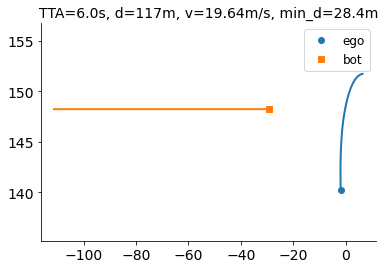

In [34]:
anim = animate_traj(traj)
HTML(anim.to_html5_video())
# HTML(anim.to_jshtml())

Let"s take a look at the time course of the trials to see if the times of bot spawn (start of decision) and response (termination of a decision) are determined correctly

In [38]:
def plot_traj(traj, fig_path="../output"):    
    idx_bot_spawn = int(traj.iloc[0].idx_bot_spawn)
    idx_response = int(traj.iloc[0].idx_response)
    idx_min_distance = int(traj.iloc[0].idx_min_distance)
    tta = int(traj.iloc[0].tta_condition)
    d = int(traj.iloc[0].d_condition)
    
    fig, axes = plt.subplots(4, 1, figsize=(12,9), sharex=True)
    axes[0].plot(traj.t, traj.ego_v, color="C0")
    axes[0].plot(traj.t[idx_bot_spawn], traj.ego_v[idx_bot_spawn], color="C7", ls="", marker="o")
    axes[0].plot(traj.t[idx_response], traj.ego_v[idx_response], color="C7", ls="", marker="x")
    axes[0].set_ylabel("ego v")

    axes[1].plot(traj.t, traj.throttle, color="C1")
    axes[1].plot(traj.t[idx_bot_spawn], traj.throttle[idx_bot_spawn], color="C7", ls="", marker="o")
    axes[1].plot(traj.t[idx_response], traj.throttle[idx_response], color="C7", ls="", marker="x")
    axes[1].set_ylabel("ego throttle")

    axes[2].plot(traj.t[:], traj.d_ego_bot[:], color="C2")
    axes[2].plot(traj.t[idx_bot_spawn], traj.d_ego_bot[idx_bot_spawn], color="C7", ls="", marker="o")
    axes[2].plot(traj.t[idx_response], traj.d_ego_bot[idx_response], color="C7", ls="", marker="x")
    axes[2].set_ylabel("d(ego to bot)")

    axes[3].plot(traj.t[:], traj.tta[:], color="C3")
    axes[3].plot(traj.t[idx_bot_spawn], traj.tta[idx_bot_spawn], color="C7", ls="", marker="o", 
                 label="Oncoming car appears")
    axes[3].plot(traj.t[idx_response], traj.tta[idx_response], color="C7", ls="", marker="x", 
                 label="Decision is made")
    axes[3].set_ylabel("tta")
    axes[3].set_ylim((0, 7))

    axes[3].set_xlabel("time $t$")

    legend = fig.legend(loc="upper left", bbox_to_anchor=(1.0, 0.9), 
                        title="TTA=%.1fs, d=%im" % (tta, d))
    legend.get_title().set_fontsize("18")
    plt.tight_layout()
    plt.savefig(os.path.join(fig_path, "%s.png" % (str(traj.iloc[0].name))))

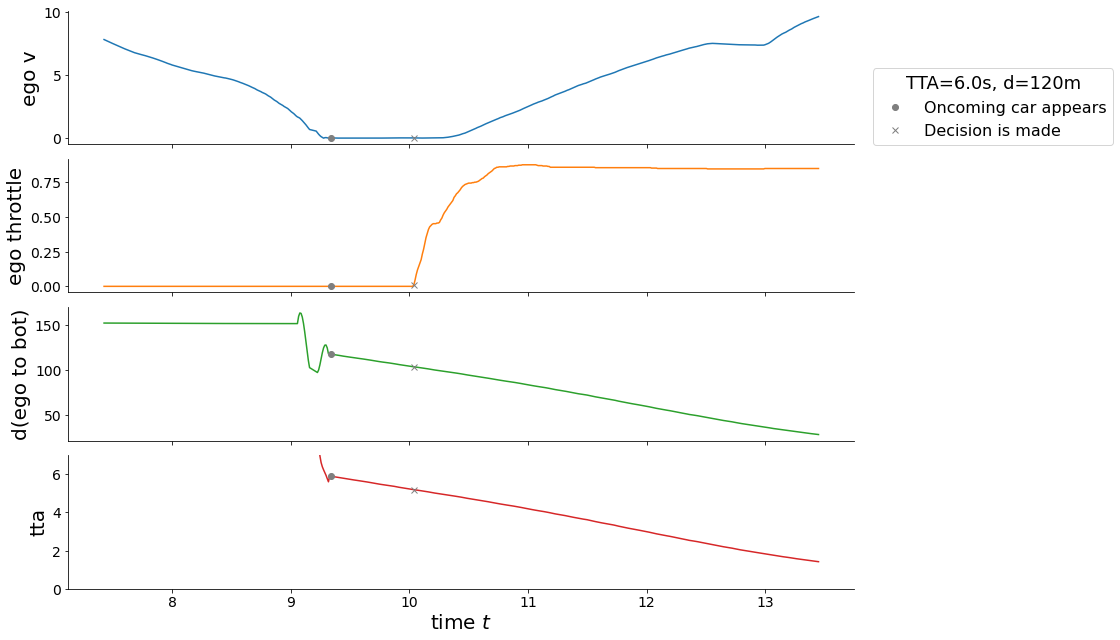

In [39]:
plot_traj(traj)

To check whether the algorithms of detecting 1) determining whether a driver decided to turn or to stay, 2) the momement the decision started (bot spawned), and 3) the moment decision was made, we save animations and time series plots for all trials

In [19]:
# for name, traj in data[data.min_distance<5].groupby(data.index.names):
#     anim = animate_traj(traj)
#     anim.save("figures/stay/%s.mp4" % (str(traj.iloc[0].name)), dpi=300)
#     plot_traj(traj, "figures/stay")
#     plt.close()

In [20]:
# for name, traj in data[data.min_distance>5].groupby(data.index.names):
#     anim = animate_traj(traj)
#     anim.save("figures/turn/%s.mp4" % (str(traj.iloc[0].name)), dpi=300)
#     plot_traj(traj, "figures/turn")
#     plt.close()

Visual inspection of all trials confirmed that the chosen algorithms accurately detect turn/stay decisions and response times. The only exception are response times in the trials where a subject started moving away but then changed their mind and decided to stay in the end. These RTs are typically short (<1s), although the decision is "stay"

<AxesSubplot:>

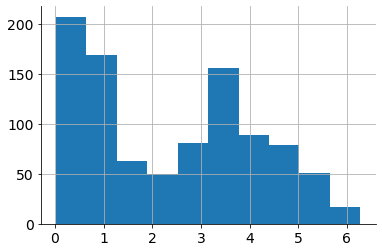

In [40]:
measures[(measures["decision"]=="Stay")].RT.hist()

In [41]:
measures[(measures.RT<1) & (measures["decision"]=="Stay")]

idx_bot_spawn  idx_response  \
subj_id session route intersection_no                                
129     1       1     5                        150.0         197.0   
                      8                        113.0         155.0   
                      14                        90.0         158.0   
                      22                       137.0         204.0   
                2     2                        141.0         208.0   
...                                              ...           ...   
996     2       7     20                       146.0         203.0   
                8     6                        208.0         256.0   
                      14                       186.0         249.0   
                      20                       144.0         180.0   
                      25                       175.0         225.0   

                                       idx_min_distance  min_distance      RT  \
subj_id session route intersection_no                                           
129     1       1     5                           507.0      3.226016  0.4837   
                      8                           574.0      3.234011  0.4339   
                      14                          483.0      3.625540  0.7579   
                      22                          609.0      3.200380  0.6907   
                2     2                           536.0      3.191600  0.7435   
...                                                 ...           ...     ...   
996     2       7     20                          515.0      3.497627  0.6007   
                8     6                           582.0      2.971505  0.5078   
                      14                          655.0      3.243308  0.6605   
                      20                          517.0      3.785852  0.3742   
                      25                          547.0      3.940858  0.5280   

                                       tta_condition  d_condition  \
subj_id session route intersection_no                               
129     1       1     5                          4.0         90.0   
                      8                          5.0         90.0   
                      14                         4.0        150.0   
                      22                         5.0        120.0   
                2     2                          4.0        150.0   
...                                              ...          ...   
996     2       7     20                         4.0        120.0   
                8     6                          4.0         90.0   
                      14                         5.0         90.0   
                      20                         4.0        120.0   
                      25                         4.0        120.0   

                                       v_condition  is_go_decision decision  
subj_id session route intersection_no                                        
129     1       1     5                       22.5           False     Stay  
                      8                       18.0           False     Stay  
                      14                      37.5           False     Stay  
                      22                      24.0           False     Stay  
                2     2                       37.5           False     Stay  
...                                            ...             ...      ...  
996     2       7     20                      30.0           False     Stay  
                8     6                       22.5           False     Stay  
                      14                      18.0           False     Stay  
                      20                      30.0           False     Stay  
                      25                      30.0           False     Stay  

[335 rows x 10 columns]

In [43]:
print(len(measures[(measures.RT<1) & (measures["decision"]=="Stay")])/len(measures[measures["decision"]=="Stay"]))

0.3482328482328482


For instance, this one

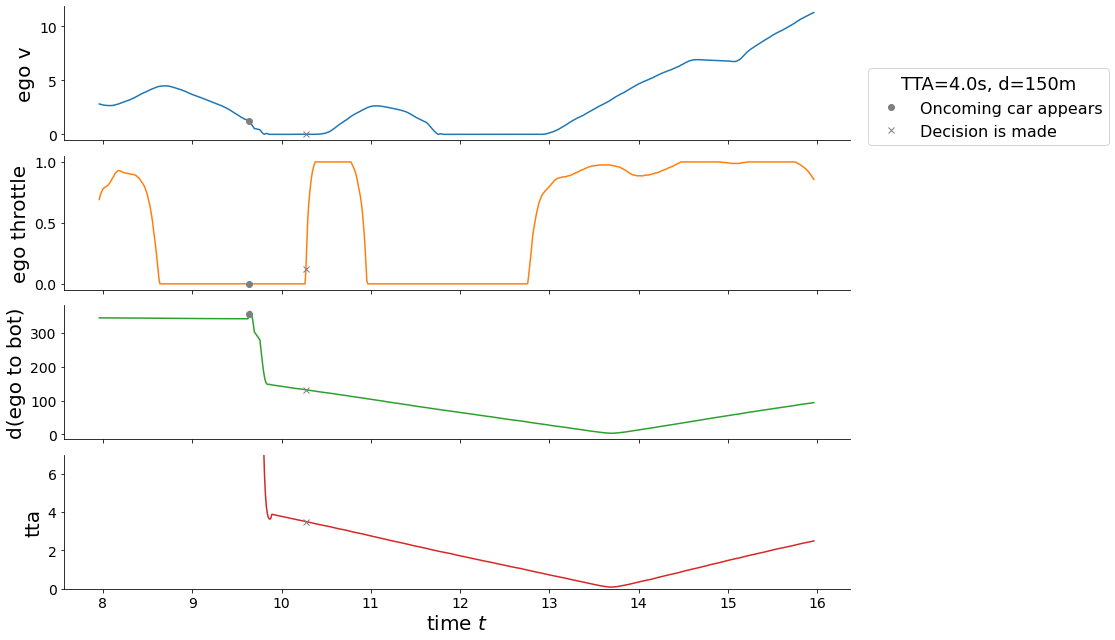

In [50]:
traj = data.loc[random.choice(measures[(measures.RT<1) & (measures["decision"]=="Stay")].index)].reset_index()
plot_traj(traj)

Some of these trials are "changes-of-mind", which will  be interesting to model, possibly using the extension of the DDM model by Resulaj et al (2009). Other trials are simply participants starting moving off slowly even though the decision is to stay, so that their car is already rolling when the oncoming car has passed

There are also cases when a driver decides to stay, but then starts slowly crawling towards the center of the intersection while the oncoming car is still approaching. RTs here tend to be between 1 and 2 seconds. These probably could be a proxy for the "stay" response times, but we don"t analyze them as well

In [51]:
measures[(measures.RT>1) & (measures.RT<2) & (measures["decision"]=="Stay")]

idx_bot_spawn  idx_response  \
subj_id session route intersection_no                                
129     1       1     20                       106.0         237.0   
                3     8                        180.0         297.0   
                      17                       190.0         328.0   
                4     1                        164.0         266.0   
                      4                        103.0         257.0   
...                                              ...           ...   
969     1       3     1                        107.0         242.0   
                4     24                       151.0         248.0   
        2       6     1                        131.0         295.0   
                7     20                       120.0         281.0   
                8     11                       117.0         243.0   

                                       idx_min_distance  min_distance      RT  \
subj_id session route intersection_no                                           
129     1       1     20                          586.0      3.380552  1.3979   
                3     8                           752.0      3.453749  1.2035   
                      17                          663.0      3.041768  1.4201   
                4     1                           522.0      3.897396  1.0495   
                      4                           683.0      3.387947  1.6232   
...                                                 ...           ...     ...   
969     1       3     1                           569.0      3.420520  1.4223   
                4     24                          703.0      3.202162  1.0269   
        2       6     1                           497.0      2.906727  1.7182   
                7     20                          571.0      3.953027  1.6898   
                8     11                          476.0      3.694152  1.3243   

                                       tta_condition  d_condition  \
subj_id session route intersection_no                               
129     1       1     20                         5.0         90.0   
                3     8                          6.0        120.0   
                      17                         5.0         90.0   
                4     1                          4.0        150.0   
                      4                          6.0         90.0   
...                                              ...          ...   
969     1       3     1                          5.0        120.0   
                4     24                         6.0         90.0   
        2       6     1                          4.0         90.0   
                7     20                         5.0         90.0   
                8     11                         4.0         90.0   

                                       v_condition  is_go_decision decision  
subj_id session route intersection_no                                        
129     1       1     20                      18.0           False     Stay  
                3     8                       20.0           False     Stay  
                      17                      18.0           False     Stay  
                4     1                       37.5           False     Stay  
                      4                       15.0           False     Stay  
...                                            ...             ...      ...  
969     1       3     1                       24.0           False     Stay  
                4     24                      15.0           False     Stay  
        2       6     1                       22.5           False     Stay  
                7     20                      18.0           False     Stay  
                8     11                      22.5           False     Stay  

[112 rows x 10 columns]

In [52]:
print(len(measures[(measures.RT>1) & (measures.RT<2) & (measures["decision"]=="Stay")]) 
      / len(measures[measures["decision"]=="Stay"]))

0.11642411642411643


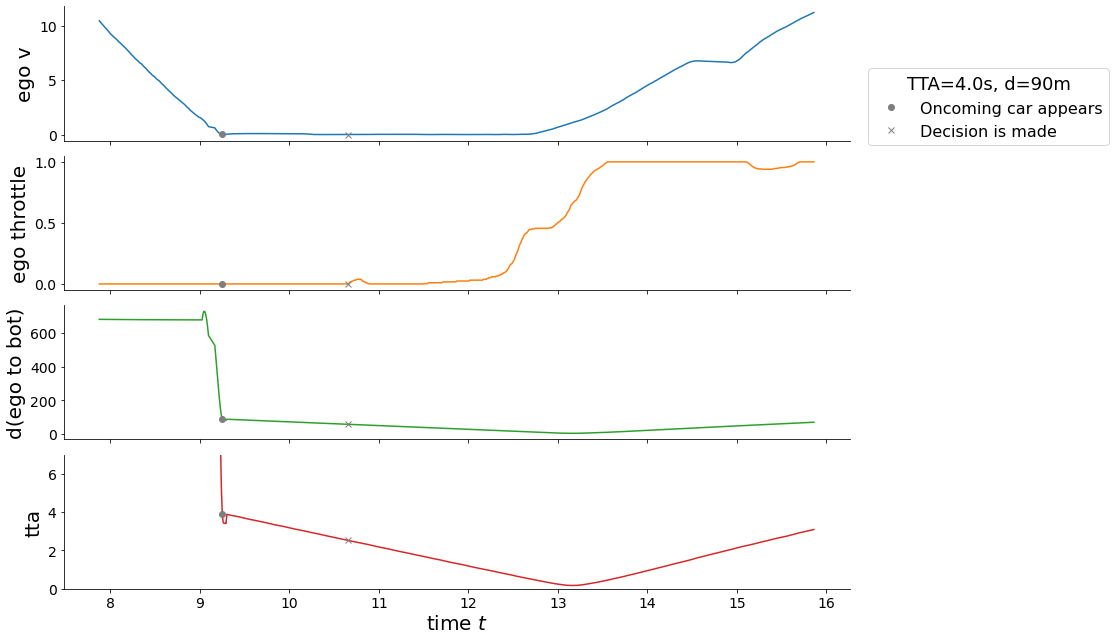

In [53]:
traj = data.loc[random.choice(measures[(measures.RT>1) & (measures.RT<2) & (measures["decision"]=="Stay")].index)].reset_index()
plot_traj(traj)

Overall share of decisions

In [62]:
print(len(measures))
print(len(measures[(measures["decision"]=="Go")])/len(measures))
print(len(measures[(measures["decision"]=="Stay")])/len(measures))

1809
0.46821448313985625
0.5317855168601437


# Collisions

<AxesSubplot:>

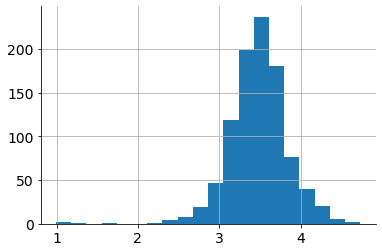

In [68]:
measures[~measures.is_go_decision].min_distance.hist(bins=20)

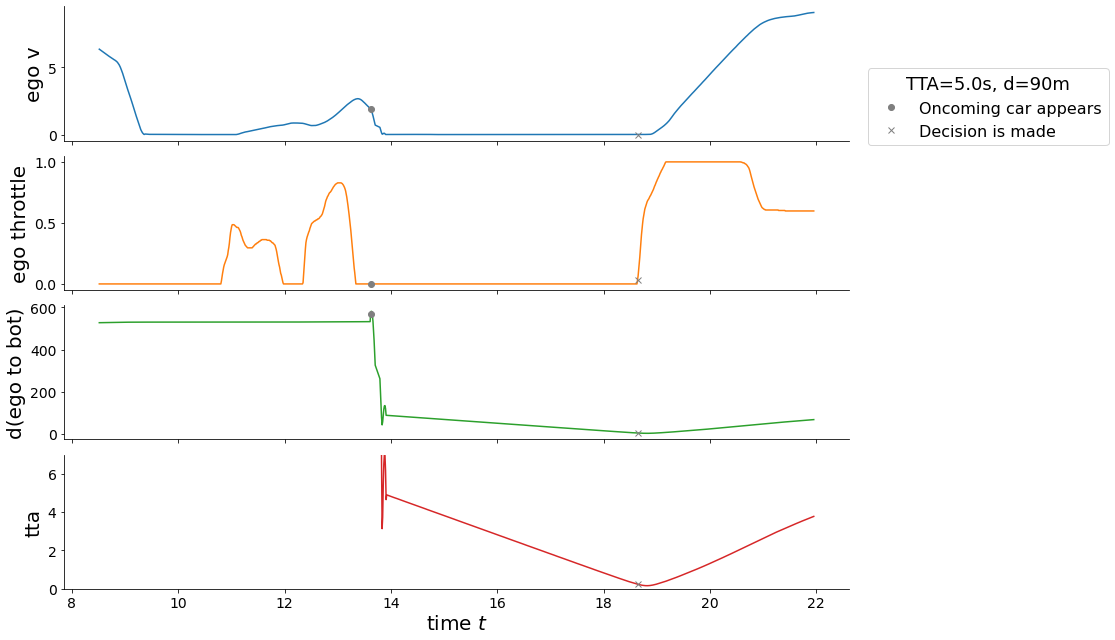

In [78]:
traj = data.loc[random.choice(measures[(measures.min_distance>2) & (measures.min_distance<3)].index)].reset_index()
plot_traj(traj)

In [64]:
measures[(measures.min_distance<2)]

idx_bot_spawn  idx_response  \
subj_id session route intersection_no                                
421     1       1     20                       282.0         351.0   
                2     6                        164.0         744.0   
755     2       6     22                       103.0         162.0   
776     1       2     6                        321.0         385.0   

                                       idx_min_distance  min_distance      RT  \
subj_id session route intersection_no                                           
421     1       1     20                          783.0      0.992167  0.7234   
                2     6                          1068.0      1.108355  6.0892   
755     2       6     22                          104.0      1.738576  0.6616   
776     1       2     6                           324.0      1.180962  0.7367   

                                       tta_condition  d_condition  \
subj_id session route intersection_no                               
421     1       1     20                         5.0        120.0   
                2     6                          6.0        120.0   
755     2       6     22                         4.0        120.0   
776     1       2     6                          5.0        150.0   

                                       v_condition  is_go_decision decision  
subj_id session route intersection_no                                        
421     1       1     20                      24.0           False     Stay  
                2     6                       20.0           False     Stay  
755     2       6     22                      30.0           False     Stay  
776     1       2     6                       30.0           False     Stay

# Effect of TTA on decision and RT

In [7]:
measures = pd.read_csv("../data/measures.csv")
measures_turn = measures[measures.is_turn_decision]

With the exception of one subject (642), probability of turning increases with time gap

In [8]:
def plot_dv_vs_iv_by_subj(measures, dv, iv):
    g = sns.catplot(kind="point", data=measures, x=iv, y=dv, hue="subj_id", join=True, dodge=0.2)
    ax = g.axes[0][0]
    sns.despine(trim=True, offset=5)
    plt.setp(ax.collections, alpha=.7)
    plt.setp(ax.lines, alpha=.7)    
    plt.setp(ax.collections, zorder=1)
    plt.setp(ax.lines, zorder=1)
    sns.pointplot(ax=ax, data=measures, x=iv, y=dv, marker="o", color="k", zorder=10)    
    plt.setp(ax.collections[-1], zorder=10)
    return ax

def plot_RT_vs_var(measures, var, hue, violin=False):
    if violin:
        g = sns.catplot(data=measures, x=var, y="RT", kind="violin", color="grey", inner=None)
        ax = g.axes[0][0]
    else:
        fig, ax = plt.subplots()
    sns.pointplot(ax=ax, data=measures, x=var, y="RT", hue=hue, dodge=0.2)
    plt.setp(ax.lines, alpha=.5)
    plt.setp(ax.collections, alpha=.5)
    sns.pointplot(ax=ax, data=measures, x=var, y="RT", color="k")
    plt.setp(ax.collections[-1], zorder=10)
    sns.despine(trim=True, offset=5)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
    ax.get_legend().set_title(hue, prop={"size":18})
    return ax

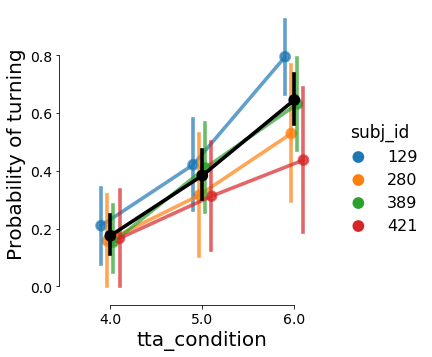

In [10]:
ax = plot_dv_vs_iv_by_subj(measures[measures.subj_id<450], dv="is_turn_decision", iv="tta_condition")
ax.set_ylabel("Probability of turning");

Now let"s see if there are any abnormalities in the RTs. We could already see in some trials that in "stay" decisions RT is very short because of "changes-of-mind", but also people would often start pressing the gas pedal before the oncoming car passes, so RT is often less than TTA even in "stay" decisions. So far we focus on the "turn" decisions, so we can ignore "stay" RTs altogether. Still, it"s intersting to see RTs for all trials (but bear in mind that some "stay" trials will have weird RTs)

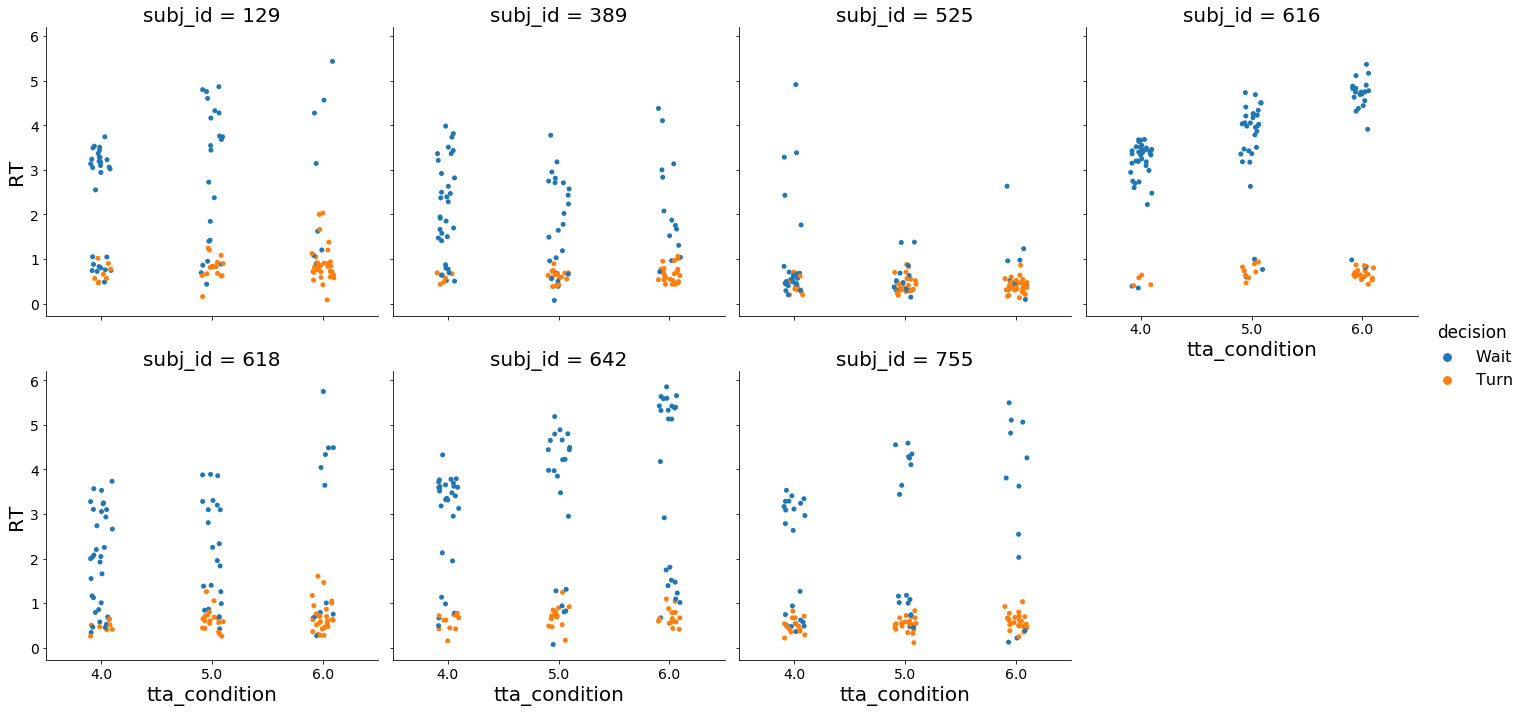

In [7]:
grid = sns.catplot(data=measures, x="tta_condition", y="RT", col="subj_id", col_wrap=4, hue="decision")

Zooming in on the "turn" decisions, we look at RTs as a function of TTA condition

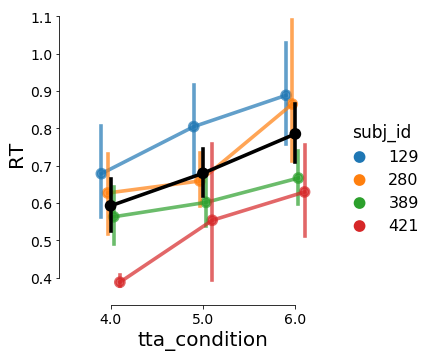

In [14]:
plot_dv_vs_iv_by_subj(measures_turn[measures_turn.subj_id<450], iv="tta_condition", dv="RT")

Interestingly, we have a positive relationship between RT and TTA condition, which isn"t what would be predicted by the constant-drift-rate DDM. The latter implies that for low-probability decisions we have longest response times, while we see the opposite picture. Is that because the drift rate in our case decreases with time? Or because TTA is not the primary perceptual variable used by the drivers? Or because it takes us longer to recognize low speed values (larger TTA)?

# Effect of distance on decision and RT

As expected, probability of turning also increases with distance

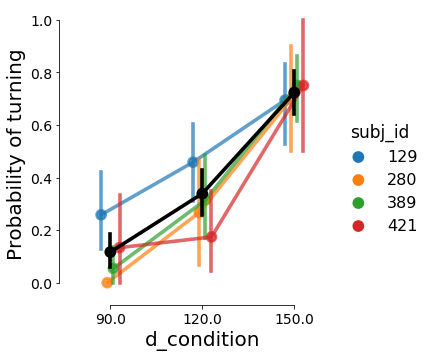

In [11]:
ax = plot_dv_vs_iv_by_subj(measures[measures.subj_id<450], iv="d_condition", dv="is_turn_decision")
ax.set_ylabel("Probability of turning");

Interestingly though, RT doesn"t seem to change with distance in general (although there are subjects for which decisions at 90m take more time) 

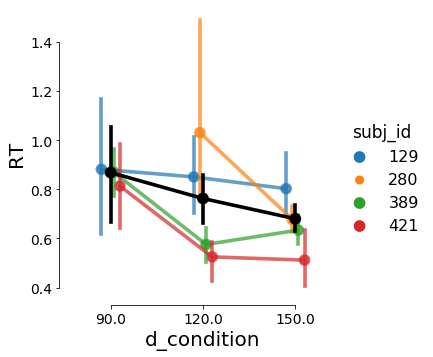

In [15]:
plot_dv_vs_iv_by_subj(measures_turn[measures_turn.subj_id<450], iv="d_condition", dv="RT");

# Aggregate data for all subjects

Let"s aggregate the data for all subjects, given that the patterns seem to be fairly consistent across the sample so far.

This is just to illustrate that probability of turning increases with both distance and TTA.

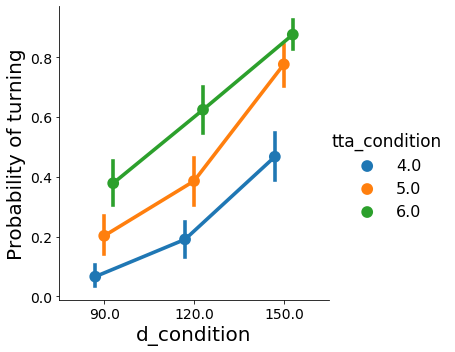

In [3]:
g = sns.catplot(kind="point", data=measures, x="d_condition", y="is_turn_decision", hue="tta_condition", join=True, dodge=0.2)
g.axes[0][0].set_ylabel("Probability of turning");

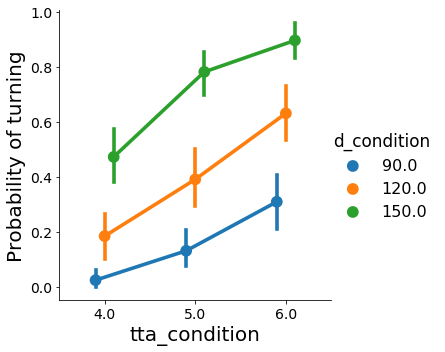

In [12]:
g = sns.catplot(kind="point", data=measures, x="tta_condition", y="is_turn_decision", hue="d_condition", join=True, dodge=0.2)
g.axes[0][0].set_ylabel("Probability of turning");

It"s interesting how difference between 90 and 120 meters is less than difference between 120 and 150 across all TTAs.  At the same time, difference between TTA=4 and TTA=5 is small at 90 meters, but is very large at 150 meters; this is reversed for difference between TTA=5 and TTA=6.

Aggregated data shows also that RT increases with TTA, except for d=90 (but note more uncertainty because of very few "turn" decisions made in this condition, especially at TTA=4)

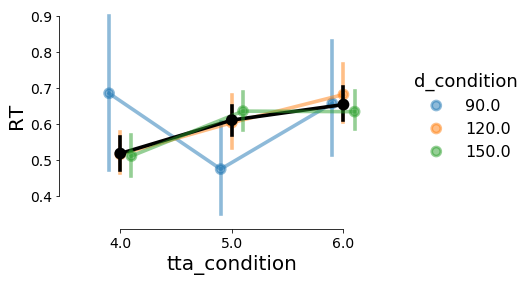

In [13]:
plot_RT_vs_var(measures_turn, var="tta_condition", hue="d_condition");

At the same time, RT does not change with distance

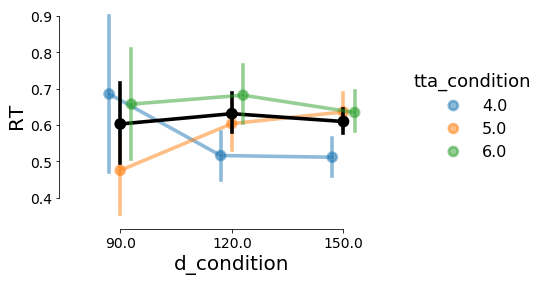

In [14]:
plot_RT_vs_var(measures_turn, var="d_condition", hue="tta_condition");

# Response time distributions

Let"s look into the RT distributions to see if there are the long tails there (we"d expect to see them for instance in the "vanilla" DDM)

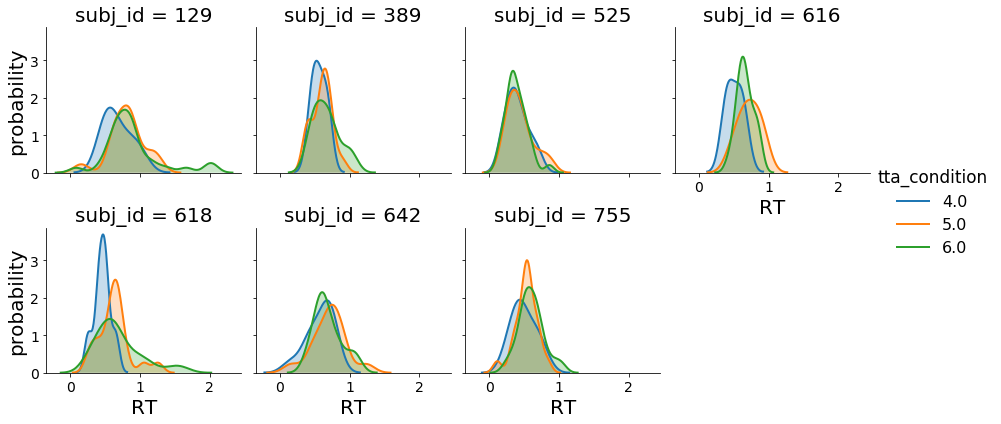

In [15]:
g = sns.FacetGrid(measures_turn, col="subj_id", hue="tta_condition", col_wrap=4)
g.map(sns.kdeplot, "RT", shade=True).add_legend().set_axis_labels("RT", "probability")

In [152]:
def plot_RT_kde(measures_turn, var, logscale=False):
    for value, group in measures_turn.groupby(var):
        ax = sns.kdeplot(group.RT, label=value, shade=True)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
    ax.get_legend().set_title(var, prop={"size":18})
    ax.set_xlabel("RT")
    ax.set_ylabel("probability")
    if logscale:
        ax.set_ylim((0.0001, 10))
        ax.set_yscale("log")
    return ax

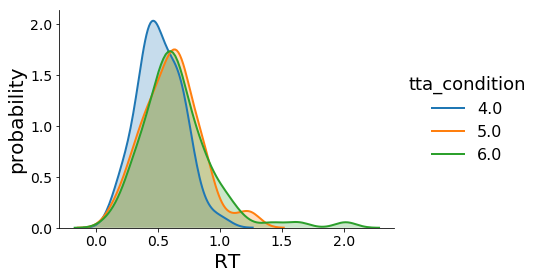

In [154]:
plot_RT_kde(measures_turn, var="tta_condition", logscale=False)

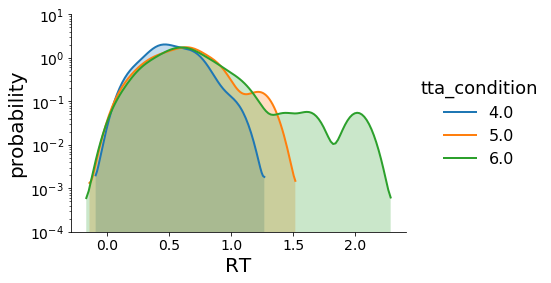

In [155]:
plot_RT_kde(measures_turn, var="tta_condition", logscale=True)

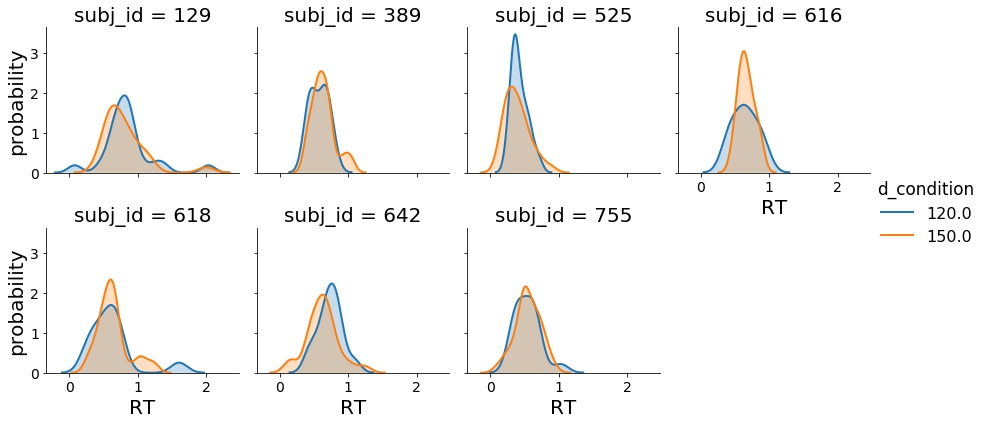

In [140]:
g = sns.FacetGrid(measures_turn[measures_turn.d_condition>90], col="subj_id", hue="d_condition", col_wrap=4)
g.map(sns.kdeplot, "RT", shade=True).add_legend().set_axis_labels("RT", "probability")

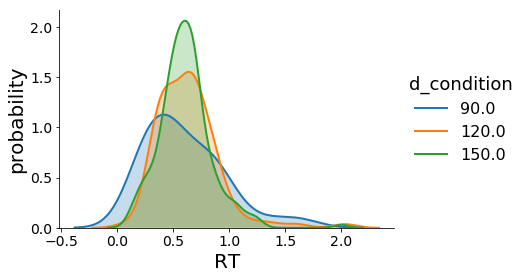

In [149]:
ax = plot_RT_kde(measures_turn, var="d_condition")

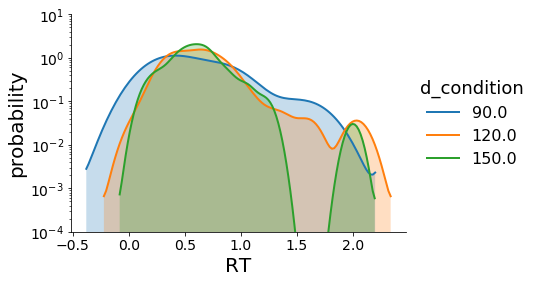

In [156]:
ax = plot_RT_kde(measures_turn, var="d_condition", logscale=True)

# Compare vincentized vs averaged distributions

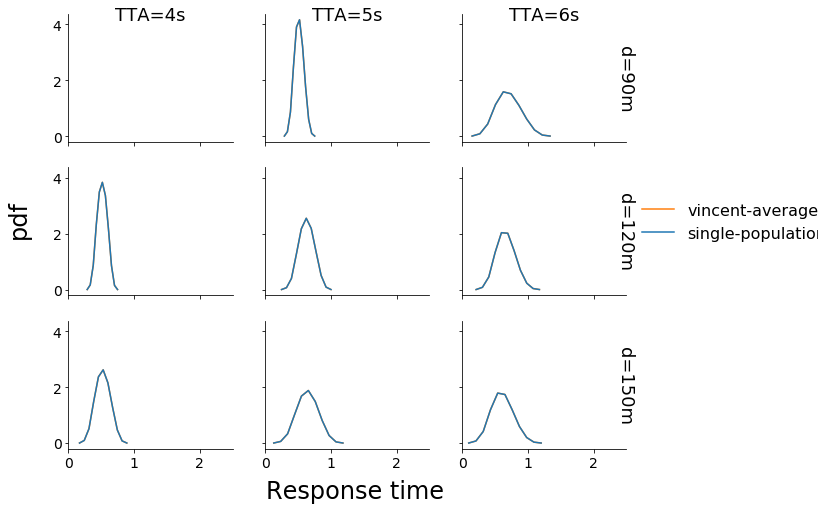

In [8]:
fig, axes = helper.plot_vincentized_rt_pdf(measures, model_rts=None, cumulative=False)
conditions = [(d, tta) 
              for d in sorted(measures.d_condition.unique()) 
              for tta in sorted(measures.tta_condition.unique())]

# q = np.linspace(0.01, 0.99, 10)
q = [0.1, 0.3, 0.5, 0.7, 0.9]

for (ax, condition) in zip(axes.flatten(), conditions):
    condition_data = measures[(measures.is_turn_decision)
                              & (measures.d_condition==condition[0]) 
                              & (measures.tta_condition==condition[1])]
    if (len(condition_data)>10):        
        condition_quantiles = condition_data.groupby("subj_id").apply(lambda d: np.quantile(a=d.RT, q=q)).mean()
        xvals = np.linspace(condition_quantiles.min(), condition_quantiles.max(), len(q))
        step = xvals[1] - xvals[0]
        data_range = np.concatenate([xvals[:3]-3*step, xvals, xvals[-3:]+step*3])
        _, data_pdf = np.histogram(condition_data.RT, bins=data_range)
        cdf = np.interp(data_range, condition_quantiles, q)
        pdf = helper.differentiate(t=data_range, x=cdf)
        ax.plot(data_range, pdf)
        
#         dist_names = ["norm", "lognorm"]
#         for dist_name in dist_names:
#             dist = getattr(scipy.stats, dist_name)
#             dist_param = dist.fit(condition_data.RT)
#             fit_x_range = np.linspace(0, condition_data.RT.max(), 20)
#             pdf_fitted = dist.pdf(fit_x_range, *dist_param[:-2], loc=dist_param[-2], scale=dist_param[-1])
#             ax.plot(fit_x_range, pdf_fitted, label=dist_name)

fig.legend(labels=["vincent-average", "single-population"], 
           loc="center", bbox_to_anchor=(1.02, 0.5), fontsize=16, frameon=False)